### Analysis of the L2 HCHO Tropomi data
- uses output from Process_HCHO_local.ipynb

**Aims**
- merge the data from repeated dates
- analyse the gridded L2 Tropomi HCHO outputs in comparison with the L2 CH4 data
- map of number of pixels with data during the time range
- interpolate Tropomi data to the resolution of the landtype and mean, min, max flood maps


In [1]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import numpy as np
import xesmf as xe
import seaborn as sns
import glob 
import os
import pandas as pd

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# load additional function from LTPY
%run ../LTPY_functions.ipynb

In [2]:
HCHO = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/TROPOMI/HCHO/gridded/'
Images = '/home/s0677837/Datastore/PHD/ALOS2/Palmer_folder/Outputs/Images/'
DATADIR = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/TROPOMI/'
DATADIR2 = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/ALOS_nc3/'

### Opening the datasets output from Process_L2_Tropomi_HCHO.ipynb

In [3]:
## The Cuvette Central region data
# all data are at 1km resolution 

# 1. RPRO HCHO data 
ds_HCHO_CC_RPRO = xr.open_dataset(HCHO + 'HCHO_RPRO_ts_1km.nc')
ds_HCHO_CC_OFFL = xr.open_dataset(HCHO + 'HCHO_OFFL_ts_1km.nc')

# 2. corresponding RMSE data
ds_HCHO_CC_RPRO_error = xr.open_dataset(HCHO + 'HCHO_RPRO_precision_ts_1km.nc') 

# changing the variable name so that it is inline with the OFFL data variable name
ds_HCHO_CC_RPRO_error = ds_HCHO_CC_RPRO_error['HCHO precision (mol m-2)'].to_dataset(name='HCHO error (mol m-2)')

ds_HCHO_CC_OFFL_error = xr.open_dataset(HCHO + 'HCHO_OFFL_precision_ts_1km.nc')

# 3. qa flags (these haven't yet been applied for the HCHO data, unlike with the CH4 data)
ds_HCHO_CC_RPRO_qa = xr.open_dataset(HCHO + 'HCHO_RPRO_qa_value_ts_1km.nc')

# changing the variable name to qa value
ds_HCHO_CC_RPRO_qa = ds_HCHO_CC_RPRO_qa['HCHO precision (mol m-2)'].to_dataset(name='qa value')

ds_HCHO_CC_OFFL_qa = xr.open_dataset(HCHO + 'HCHO_OFFL_qa_value_ts_1km.nc')

# landtype map corresponding with the ALOS area
lt_map = xr.open_dataset(DATADIR2 + 'landtype_100m.nc')

# full CC map
lt_map_CC = xr.open_rasterio(DATADIR2 + 'Crezee_2022_Smoothed_7x7_Classification_Most_likely_class.tif')

# Terre firme water level linear interpolation
wl_tf = xr.open_dataset(DATADIR2 + 'HH_linear_ts_terrefirme.nc')

# Final water level map for peatland pixels (100m resolution)
wl_final = xr.open_dataset(DATADIR2 + 'WL_daily_final.nc')


### Function declarations

In [4]:
def merge_repeated_timesteps(ds, var_name):
    # Remove empty time steps and merging data from non-empty repeated ones
    # example usage:  ds_methane_new = merge_repeated_timesteps(ds_methane, 'Methane (ppb)')
    
    da = ds[var_name].copy()

    # first remove all dates with no data at all
    da = da.dropna(dim='time', how='all')

    print ('Empty time steps (these have been removed): ' + str(len(ds[var_name]) - len(da)))
    
    # combining the pixels from multiple images that have the same dates (occassionally 2 or 3 images are from the same date, and slightly differenct tracks)
    da = da.groupby('time').max()
    
    ds_new = da.to_dataset(name=var_name)
    ds_new

    return ds_new

In [5]:
def merge_data(ds,var_name):
    # function to merge data where there are more than 1 image with the same date, and to drop dates with no data availability
    # This has the same functionality as merge_repeated_timesteps, but works more comprehensively across different regions for some reason 
    # (it's basically just a reversal of the steps order)
    
    # using the max function, pixels with no data will have nan values
    ds = ds.groupby('time').max()
    
    # dropping images with no data
    ds = ds[var_name].dropna(dim='time', how='all').to_dataset(name=var_name)
    return ds

In [6]:
def combine_offl_rpro(rpro_ds,offl_ds,var_name,offl_index):
    ## function to fill in the reprocessed (RPRO) data missing timesteps with the offline (OFFL) data
    da_subset = offl_ds[var_name][offl_index:]
    ds_final = rpro_ds[var_name].combine_first(da_subset).to_dataset(name = var_name)
    return ds_final 

In [7]:
def plot_CH4_hist(da,xlim1,xlim2,a_loc,title_str, output_file):
    # example usage: plot_CH4_hist(da, 1400, 2100, 400000 'Cuvette Centrale','CC_hist.png')
    # da = xarray data array
    # xlim1 and xlim2 = the x range of the graph
    # a_loc = the y range location of the annotation
    
    a = da.plot.hist(bins=1000, xlim=(xlim1,xlim2));
    mean_val = da.mean()
    plt.vlines([mean_val],ymin=0,ymax=a[0].max(), color='red',linestyle='dashed',linewidth=1)
    plt.title(title_str + '\ndistribution of $XCH_4$ (ppb) for 2018 to 2023')

    plt.annotate('mean = ' + str(np.round(mean_val.values,5)) + ' ppb', (0.0005,a_loc))
    plt.savefig(Images + output_file)

### Merging data with the same timesteps

In [8]:
%%time
# CC region - removing empty time steps and merging data from non-empty repeated ones
#ds_HCHO_CC = merge_repeated_timesteps(ds_HCHO_CC, 'HCHO (mol m-2)')
ds_HCHO_RPRO = merge_data(ds_HCHO_CC_RPRO, 'HCHO (mol m-2)')

#print(len(ds_HCHO_CC['HCHO (mol m-2)']), len(ds_HCHO_CC_RPRO['HCHO (mol m-2)']))
print (len(ds_HCHO_RPRO['HCHO (mol m-2)']))

1534
CPU times: user 8.24 s, sys: 6.27 s, total: 14.5 s
Wall time: 14.5 s


In [9]:
%%time
ds_HCHO_RPRO_error = merge_data(ds_HCHO_CC_RPRO_error, 'HCHO error (mol m-2)')

ds_HCHO_RPRO_QA = merge_data(ds_HCHO_CC_RPRO_qa, 'qa value')


CPU times: user 16.2 s, sys: 13 s, total: 29.2 s
Wall time: 29.3 s


In [10]:
%%time
# similarily with the OFFL data 
ds_HCHO_OFFL = merge_data(ds_HCHO_CC_OFFL, 'HCHO (mol m-2)')
ds_HCHO_OFFL_error = merge_data(ds_HCHO_CC_OFFL_error, 'HCHO error (mol m-2)')
ds_HCHO_OFFL_QA = merge_data(ds_HCHO_CC_OFFL_qa, 'qa value')

CPU times: user 6.65 s, sys: 7.35 s, total: 14 s
Wall time: 1min 11s


### Filter the data and associated errors using qa value > 0.5

In [11]:
%%time
# filter by qa value > 0.5
da = ds_HCHO_RPRO['HCHO (mol m-2)'].where(ds_HCHO_RPRO_QA['qa value']> 0.5)
ds_HCHO_RPRO = da.to_dataset(name='HCHO (mol m-2)')

da = ds_HCHO_OFFL['HCHO (mol m-2)'].where(ds_HCHO_OFFL_QA['qa value']> 0.5)
ds_HCHO_OFFL = da.to_dataset(name='HCHO (mol m-2)')

CPU times: user 2.58 s, sys: 9.75 s, total: 12.3 s
Wall time: 14.8 s


In [12]:
%%time
da = ds_HCHO_RPRO_error['HCHO error (mol m-2)'].where(ds_HCHO_RPRO_QA['qa value']> 0.5)
ds_HCHO_RPRO_error = da.to_dataset(name='HCHO error (mol m-2)')

da = ds_HCHO_OFFL_error['HCHO error (mol m-2)'].where(ds_HCHO_OFFL_QA['qa value']> 0.5)
ds_HCHO_OFFL_error = da.to_dataset(name='HCHO error (mol m-2)')

CPU times: user 2.73 s, sys: 4.62 s, total: 7.35 s
Wall time: 8.67 s


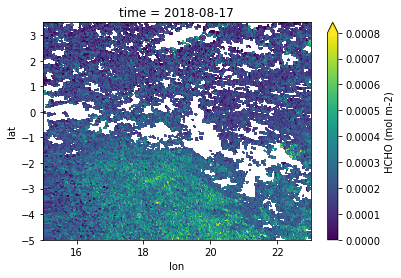

In [13]:
ds_HCHO_RPRO['HCHO (mol m-2)'][100].plot(vmin=0, vmax=0.0008)

### Filling in gaps with OFFL data 
- see Analyse_L2_Tropomi_CH4.ipynb
- should images with a mean value of 0 be removed? Is it likely that there will be days with no observable HCHO?

In [ ]:
# Checking the OFFL product index that the RPRO and OFFL data should be combined at


In [ ]:
## now filling in the reprocessed (RPRO) data missing timesteps with the offline (OFFL) data
var_name = 'HCHO (mol m-2)'
ds_HCHO_CC_final = combine_offl_rpro(ds_HCHO_RPRO, ds_HCHO_OFFL, var_name,1211)
ds_methane_CC_final

### Counting the number of dates with valid HCHO retrievals

In [14]:
# interpolating the landtype map to 1km (same as the interpolated TROPOMI data)
lt = lt_map_CC.rename({'x':'lon','y':'lat'})
lt = lt[0].to_dataset(name='type')

# reversing lat values
lt = lt.reindex(lat=lt.lat[::-1])

# low resolution land type map (1km)
lt_trop = lt.interp_like(ds_HCHO_RPRO['HCHO (mol m-2)'][0])

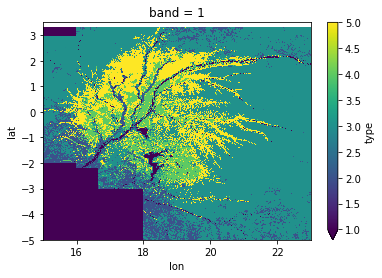

In [11]:
lt_trop['type'].plot(vmin=1, vmax=5)

In [15]:
# reformatting the 1km resolution landtype map
lt_df = lt_trop.to_dataframe().reset_index()
lt_df.drop(columns = ['band'], inplace=True)
lt_df['type'] = np.round(lt_df['type'],0)
lt_df = lt_df.dropna().reset_index(drop=True)

lt_df['type'] = lt_df['type'].astype(int)
lt_df = lt_df[lt_df['type'].isin([1.0,2.0,3.0,4.0,5.0])].reset_index(drop=True)
lt_ds = lt_df.set_index(['lat','lon']).to_xarray()
lt_ds

<xarray.Dataset>
Dimensions:  (lat: 922, lon: 888)
Coordinates:
  * lat      (lat) float64 -4.991 -4.982 -4.973 -4.964 ... 3.284 3.293 3.302
  * lon      (lon) float64 15.01 15.02 15.03 15.04 ... 22.97 22.98 22.99 23.0
Data variables:
    type     (lat, lon) float64 nan nan nan nan nan nan ... 3.0 3.0 3.0 3.0 3.0

In [16]:
title_str = 'Cuvette Centrale peatland'
da = ds_HCHO_RPRO.where(lt_ds['type'].isin([4.0,5.0]))['HCHO (mol m-2)']
#da
#plot_CH4_hist(da,-0.004,0.004,60000, title_str,'CC_HCHO_peatland_hist.png')

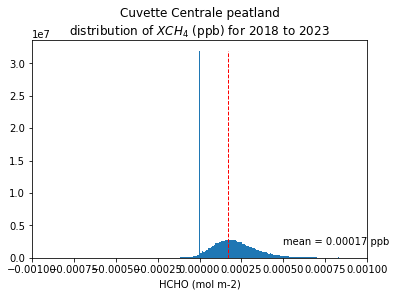

In [88]:
plot_CH4_hist(da,-0.001,0.001,2000000, title_str,'CC_HCHO_peatland_hist.png')

In [17]:
da1 = da.mean(dim='time')

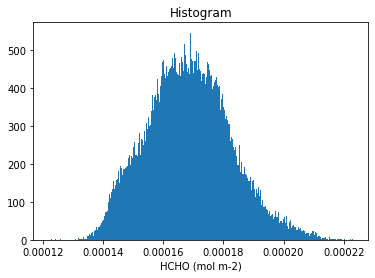

In [90]:
da1.plot.hist(bins=1000);

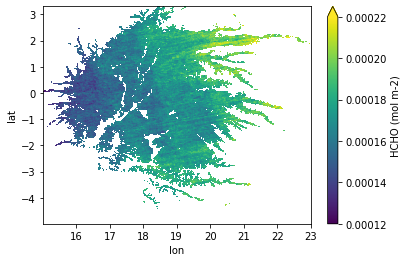

In [94]:
da1.plot(cmap='viridis', vmin = 0.00012,vmax=0.00022)
plt.savefig(Images + 'HCH0_mean_2018_2022.png')

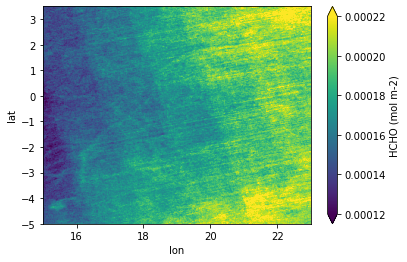

In [93]:
da = ds_HCHO_RPRO['HCHO (mol m-2)'].mean(dim='time')
da.plot(cmap='viridis', vmin = 0.00012,vmax=0.00022)
plt.savefig(Images + 'HCHO_mean_full_CC.png')

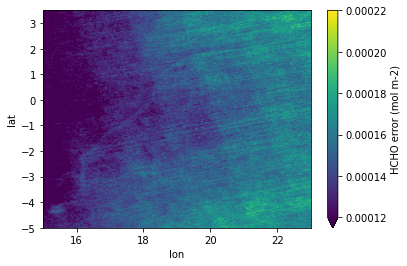

In [95]:
da = ds_HCHO_RPRO_error['HCHO error (mol m-2)'].mean(dim='time')
da.plot(cmap='viridis', vmin = 0.00012,vmax=0.00022)
plt.savefig(Images + 'HCHO_mean_full_CC_error.png')

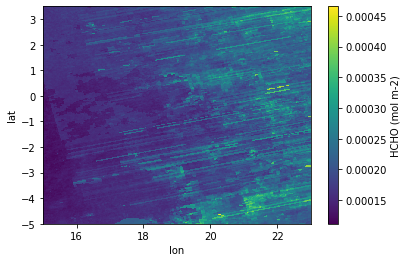

In [96]:
da = ds_HCHO_RPRO['HCHO (mol m-2)'].std(dim='time')
da.plot(cmap='viridis')
plt.savefig(Images + 'HCHO_stdev_full_CC.png')

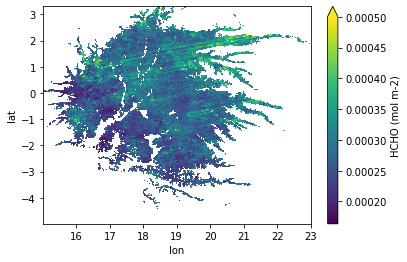

In [60]:
da2 = da.std(dim='time')
da2.plot(cmap='viridis', vmax=0.0005)
plt.savefig(Images + 'HCH0_std_2018_2022.png')

### Methane code (see Analyse_L2_Tropomi_CH4.ipynb)

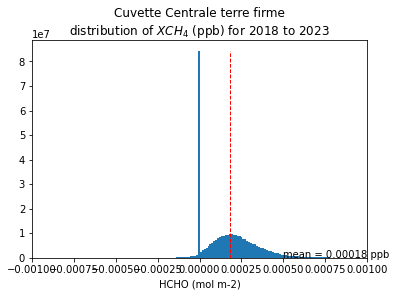

In [99]:
# less variability in the terre firme CH4 concentration
title_str = 'Cuvette Centrale terre firme'
da = ds_HCHO_RPRO.where(lt_ds['type'].isin([3.0]))['HCHO (mol m-2)']
plot_CH4_hist(da,-0.001,0.001,200000, title_str,'CC_HCHO_tf_hist.png')

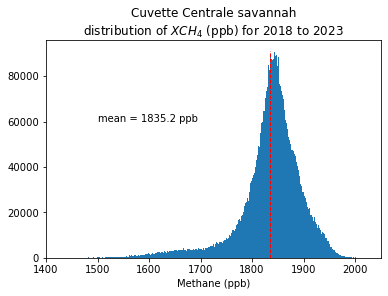

In [18]:
# less variability in the savannah CH4 concentration
title_str = 'Cuvette Centrale savannah'
da = ds_methane_CC_final.where(lt_ds['type'].isin([2.0]))['Methane (ppb)']
plot_CH4_hist(da,1400,2050,60000, title_str,'CC_CH4_savannah_hist.png')

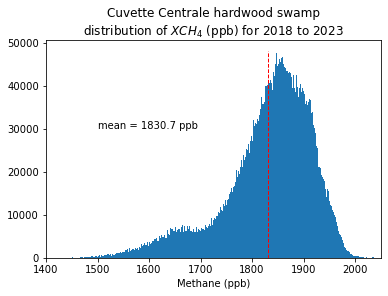

In [19]:
# hardwood swamp only
title_str = 'Cuvette Centrale hardwood swamp'
da = ds_methane_CC_final.where(lt_ds['type'].isin([5.0]))['Methane (ppb)']
plot_CH4_hist(da,1400,2050,30000, title_str,'CC_CH4_hws_hist.png')


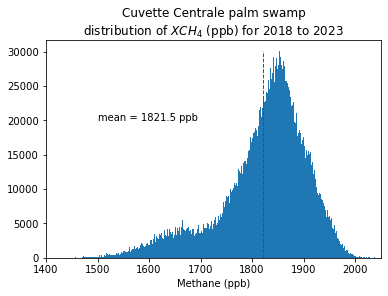

In [24]:
# palm swamp only
title_str = 'Cuvette Centrale palm swamp'
da = ds_methane_CC_final.where(lt_ds['type'].isin([4.0]))['Methane (ppb)']
plot_CH4_hist(da,1400,2050,20000, title_str,'CC_CH4_ps_hist.png')


In [90]:
# using the 1km resolution landtype map to calculate the background CH4 concentration
#lt_ds['type'].plot()
for i in range (1,6):
    print (i)
    print (ds_methane_CC_final.where(lt_ds['type'] == i)['Methane (ppb)'].mean())

1
<xarray.DataArray 'Methane (ppb)' ()>
array(1815.65359727)
2
<xarray.DataArray 'Methane (ppb)' ()>
array(1834.82414709)
3
<xarray.DataArray 'Methane (ppb)' ()>
array(1832.56487797)
4
<xarray.DataArray 'Methane (ppb)' ()>
array(1821.16502577)
5
<xarray.DataArray 'Methane (ppb)' ()>
array(1830.28472087)


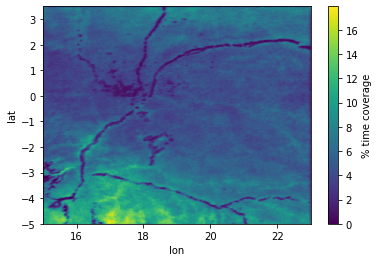

In [92]:
# Calculating the % of time there is TROPOMI data coverage
# over full CC 
ds_count_days = ds_methane_CC_final['Methane (ppb)'].count(dim='time')
ds_count = ds_count_days*100/len(ds_methane_CC_final.time)
ds_count = ds_count.to_dataset(name='% time coverage')

#ds_count = ds_count.where(lt['type'].isin([4,5]))
#plt.figure(figsize=[7,4.8])
ds_count['% time coverage'].plot()
plt.savefig(Images + 'Tropomi_counts.png', bbox_inches='tight')

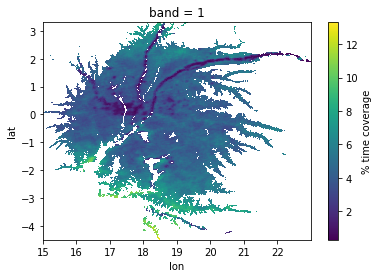

In [93]:
ds = ds_count.interp_like(lt['type'])
ds = ds.where(lt['type'].isin([4,5]))
ds = ds.where((ds.lon < 23) & (ds.lat > -4.5), drop=True)
ds['% time coverage'][::10,::10].plot()
plt.savefig(Images + 'Tropomi_counts.png', bbox_inches='tight')

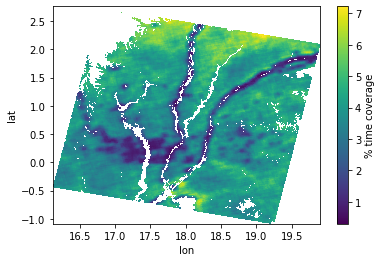

In [94]:
# over ALOS-2 image region
ds = ds_count.interp_like(lt_map)
ds = ds.where(lt_map['type'].isin([4,5]))
wl_ds = wl_final['water_level'][0]
ds = ds.where(wl_ds.notnull())
ds['% time coverage'].plot()
plt.title('')
plt.savefig(Images + 'Tropomi_counts_ALOS.png', bbox_inches='tight')

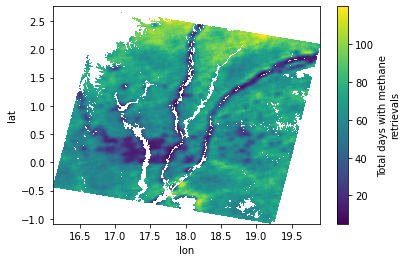

In [97]:
# over the ALOS region
ds = ds_count_days.interp_like(lt_map)
ds = ds.where(lt_map['type'].isin([4,5]))
wl_ds = wl_final['water_level'][0]
ds = ds.where(wl_ds.notnull())
ds['Total days with methane retrievals'].plot()
plt.title('')
plt.savefig(Images + 'Tropomi_counts_ALOS_days.png', bbox_inches='tight')

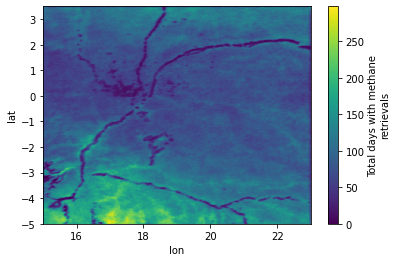

In [100]:
#ds_count_days = ds_count_days.to_dataset(name = 'Total days with methane retrievals')
ds_count_days['Total days with methane retrievals'].plot()
plt.savefig(Images + 'Tropomi_counts_days.png', bbox_inches='tight')

### Creating daily arrays of CH4 and water level
- loops through all dates (less computationally expensive than applying across the whole dataset at once)
- for each water level pixel, extract the corresponding methane retrieval 

In [67]:
# subsetting to the ALOS extents

wl_ds = wl_final['water_level'][0]
lat_min2 = wl_ds.lat.min()
lat_max2 = wl_ds.lat.max()
lon_min2 = wl_ds.lon.min()
lon_max2 = wl_ds.lon.max()

ds_sub = ds_HCHO_RPRO.where((ds_HCHO_RPRO.lat >= lat_min2) & (ds_HCHO_RPRO.lat <= lat_max2) & (ds_HCHO_RPRO.lon >= lon_min2) \
                             & (ds_HCHO_RPRO.lon <= lon_max2), drop=True)

In [68]:
ds_sub

<xarray.Dataset>
Dimensions:         (lat: 427, lon: 421, time: 855)
Coordinates:
  * lon             (lon) float64 16.12 16.13 16.14 16.14 ... 19.88 19.89 19.9
  * lat             (lat) float64 -1.083 -1.074 -1.065 ... 2.735 2.744 2.753
  * time            (time) datetime64[ns] 2018-05-14 2018-05-15 ... 2022-08-02
    band            int64 1
Data variables:
    HCHO (mol m-2)  (time, lat, lon) float64 0.0002846 0.0002846 ... 0.0001134

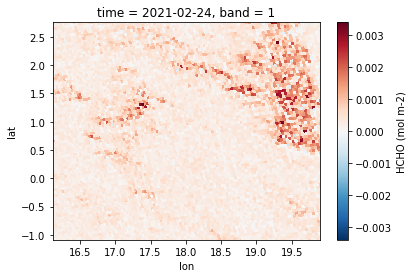

In [69]:
ds_sub['HCHO (mol m-2)'][500].plot()

## Full CC comparisons

In [70]:
# monthly means
ds = ds_HCHO_RPRO
CC_HCHO_mean = ds['HCHO (mol m-2)'].groupby('time.month').mean()
#CC_ch4_mean

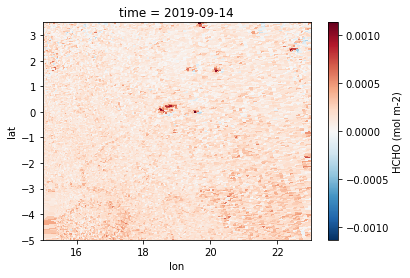

In [89]:
ds_HCHO_RPRO['HCHO (mol m-2)'][321].plot()

In [71]:
# grouping by month and year
ds1 = ds_HCHO_RPRO['HCHO (mol m-2)'].resample(time='1M').mean().to_dataset(name='mean HCHO (mol m-2)')
ds2 = ds_HCHO_RPRO['HCHO (mol m-2)'].resample(time='1M').std().to_dataset(name = 'RMSE HCHO (mol m-2)')
ds_monthly = xr.merge([ds1,ds2])
ds_monthly

<xarray.Dataset>
Dimensions:              (lat: 945, lon: 889, time: 52)
Coordinates:
  * time                 (time) datetime64[ns] 2018-05-31 ... 2022-08-31
  * lon                  (lon) float64 15.0 15.01 15.02 ... 22.98 22.99 23.0
  * lat                  (lat) float64 -5.0 -4.991 -4.982 ... 3.482 3.491 3.5
Data variables:
    mean HCHO (mol m-2)  (time, lat, lon) float64 0.0001333 ... 5.168e-05
    RMSE HCHO (mol m-2)  (time, lat, lon) float64 0.000152 ... 5.168e-05

In [73]:
ds1

<xarray.Dataset>
Dimensions:              (lat: 945, lon: 889, time: 52)
Coordinates:
  * time                 (time) datetime64[ns] 2018-05-31 ... 2022-08-31
  * lon                  (lon) float64 15.0 15.01 15.02 ... 22.98 22.99 23.0
  * lat                  (lat) float64 -5.0 -4.991 -4.982 ... 3.482 3.491 3.5
Data variables:
    mean HCHO (mol m-2)  (time, lat, lon) float64 0.0001333 ... 5.168e-05

mean: <xarray.DataArray 'mean HCHO (mol m-2)' ()>
array(nan)
Coordinates:
    time     datetime64[ns] 2020-03-31


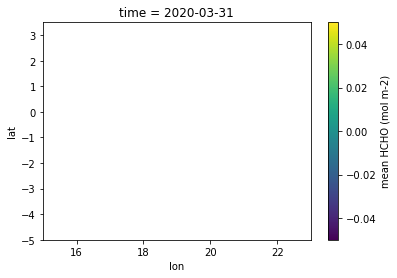

In [78]:
da = ds1['mean HCHO (mol m-2)'][22]
da.plot()
print ('mean: ' + str(da.mean()))

mean: <xarray.DataArray 'mean Methane (ppb)' ()>
array(1877.94265829)
Coordinates:
    time     datetime64[ns] 2020-03-31


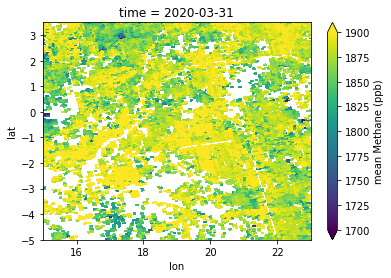

In [29]:
da = ds1['mean Methane (ppb)'][15]
da.plot(vmin=1700,vmax=1900)
print ('mean: ' + str(da.mean()))

In [30]:
ch4_months = pd.DataFrame(columns=['Month','All landtypes', 'Savannah','Terra firme','Hardwood swamp','Palm swamp','All landtypes stdev', 'Savannah stdev', \
                                   'Terra firme stdev','Hardwood swamp stdev','Palm swamp stdev'])
ch4_months

Empty DataFrame
Columns: [Month, All landtypes, Savannah, Terra firme, Hardwood swamp, Palm swamp, All landtypes stdev, Savannah stdev, Terra firme stdev, Hardwood swamp stdev, Palm swamp stdev]
Index: []

In [31]:
# low resolution land type map (1km)
lt_1km = lt_map.interp_like(ds_methane_CC['Methane (ppb)'][0])
lt_1km

<xarray.Dataset>
Dimensions:  (lat: 945, lon: 889)
Coordinates:
    band     int64 ...
  * lat      (lat) float64 -5.0 -4.991 -4.982 -4.973 ... 3.473 3.482 3.491 3.5
  * lon      (lon) float64 15.0 15.01 15.02 15.03 ... 22.97 22.98 22.99 23.0
Data variables:
    type     (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [75]:
# monthly climatology over the 5 year period 
# add Bateke region average for the savannah pixels, requires a landtype map
# convert this into a pandas dataframe and then plot
ds = CC_ch4_mean
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
ch4_months['Month'] = months
all_vals = []
sav = []
tf = []
ps = []
hws = []
water = []

all_vals_stdev = []
sav_stdev  = []
tf_stdev  = []
ps_stdev  = []
hws_stdev  = []
water_stdev = []

for i in range(len(ds)):
    if i ==0:
        print ('Month','All', 'Savannah', 'Terra Firme', 'Hardwood swamp', 'Palm swamp')
    all_vals.append(np.round(ds[i].where(lt_1km['type'].isin([1,2,3,4,5])).mean().values,1))
    #all_vals.append(np.round(ds[i].where(lt_1km['type'].isin([2,3,4,5])).mean().values,1))
    water.append(np.round(ds[i].where(lt_1km['type'].isin([1])).mean().values,1))
    sav.append(np.round(ds[i].where(lt_1km['type'].isin([2])).mean().values,1))
    tf.append(np.round(ds[i].where(lt_1km['type'].isin([3])).mean().values,1))
    ps.append(np.round(ds[i].where(lt_1km['type'].isin([4])).mean().values,1))
    hws.append(np.round(ds[i].where(lt_1km['type'].isin([5])).mean().values,1))
    
    all_vals_stdev.append(np.round(ds[i].where(lt_1km['type'].isin([1,2,3,4,5])).std().values,1))
    #all_vals_stdev.append(np.round(ds[i].where(lt_1km['type'].isin([2,3,4,5])).std().values,1))
    water_stdev.append(np.round(ds[i].where(lt_1km['type'].isin([1])).std().values,1))
    sav_stdev.append(np.round(ds[i].where(lt_1km['type'].isin([2])).std().values,1))
    tf_stdev.append(np.round(ds[i].where(lt_1km['type'].isin([3])).std().values,1))
    ps_stdev.append(np.round(ds[i].where(lt_1km['type'].isin([4])).std().values,1))
    hws_stdev.append(np.round(ds[i].where(lt_1km['type'].isin([5])).std().values,1))
    #print (months[i], all_vals,sav, tf, hws, ps)


ch4_months['All landtypes'] = all_vals
ch4_months['Water'] = water
ch4_months['Savannah'] = sav
ch4_months['Terra firme'] = tf
ch4_months['Hardwood swamp'] = hws
ch4_months['Palm swamp'] = ps

ch4_months['All landtypes stdev'] = all_vals_stdev
ch4_months['Water stdev'] = water_stdev
ch4_months['Savannah stdev'] = sav_stdev
ch4_months['Terra firme stdev'] = tf_stdev
ch4_months['Hardwood swamp stdev'] = hws_stdev
ch4_months['Palm swamp stdev'] = ps_stdev

ch4_months

Month All Savannah Terra Firme Hardwood swamp Palm swamp


Month  All landtypes  Savannah  Terra firme  Hardwood swamp  Palm swamp  \
0    Jan         1888.3    1899.7       1886.9          1886.3      1894.5   
1    Feb         1901.3    1908.9       1898.1          1901.4      1905.5   
2    Mar         1869.5    1878.1       1864.9          1870.5      1874.1   
3    Apr         1831.2    1849.0       1819.9          1832.8      1843.1   
4    May         1826.9    1844.0       1828.1          1827.0      1821.4   
5    Jun         1820.1    1835.7       1815.1          1820.2      1826.4   
6    Jul         1743.6    1752.9       1745.7          1745.7      1734.7   
7    Aug         1697.5    1700.8       1698.7          1697.5      1695.4   
8   Sept         1802.0    1813.6       1808.3          1796.9      1798.8   
9    Oct         1819.3    1833.1       1821.4          1817.3      1817.5   
10   Nov         1829.3    1849.0       1827.7          1825.6      1834.5   
11   Dec         1844.9    1847.3       1852.2          1843.2      1837.8   

    All landtypes stdev  Savannah stdev  Terra firme stdev  \
0                  19.5            18.0               17.9   
1                  15.9            17.4               13.8   
2                  21.2            26.4               20.9   
3                  41.6            39.3               42.9   
4                  37.2            31.7               33.2   
5                  25.0            20.3               26.0   
6                  51.0            54.4               49.8   
7                  31.6            33.3               32.9   
8                  36.9            33.9               35.8   
9                  35.7            28.7               34.5   
10                 35.8            27.9               34.1   
11                 34.6            48.1               28.7   

    Hardwood swamp stdev  Palm swamp stdev   Water  Water stdev  
0                   18.2              20.9  1881.1         34.7  
1                   14.5              18.3  1902.1         31.8  
2                   19.1              19.6  1872.7         46.1  
3                   39.5              38.1  1831.3         51.9  
4                   38.2              40.8  1823.1         43.2  
5                   24.6              19.6  1819.2         36.5  
6                   51.6              48.6  1730.2         57.5  
7                   31.3              28.9  1693.1         33.3  
8                   37.4              32.4  1799.3         57.8  
9                   36.4              36.0  1814.0         41.7  
10                  35.8              37.7  1846.3         35.5  
11                  33.9              35.5  1824.8         56.4

In [76]:
ch4_months2 = ch4_months.append(ch4_months.loc[0]).reset_index()

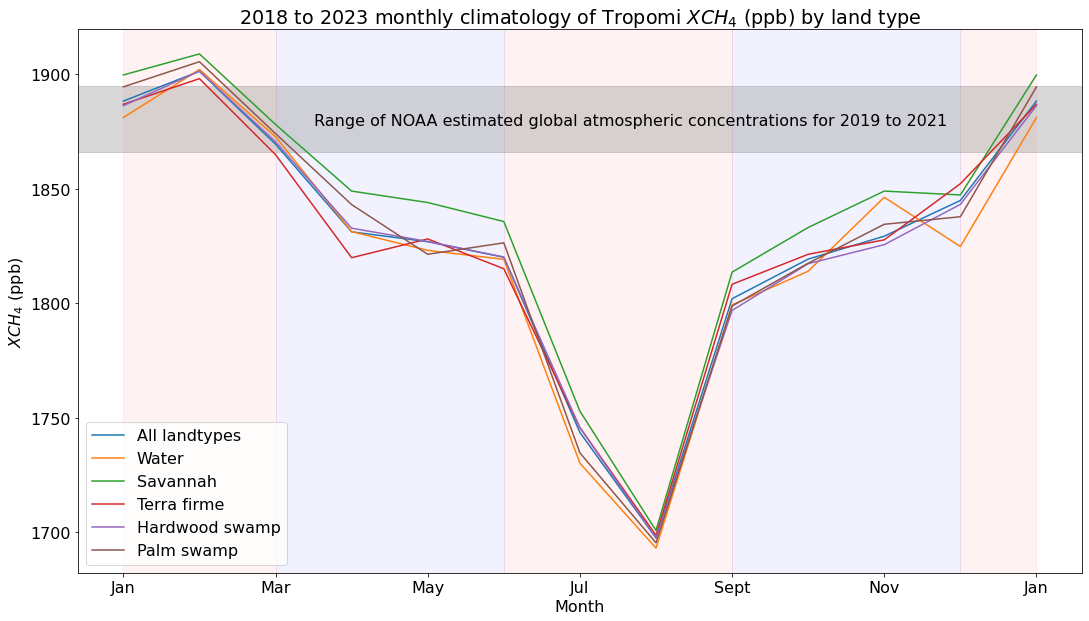

In [77]:
# make this plot better - add standard deviation envelopes
plt.rcParams.update({'font.size':16})
ax = ch4_months2.plot('Month',['All landtypes','Water','Savannah','Terra firme','Hardwood swamp', 'Palm swamp'], figsize=(18,10), \
                     title = '2018 to 2023 monthly climatology of Tropomi $XCH_4$ (ppb) by land type')
ax.set_ylabel("$XCH_4$ (ppb)")

ax.axvspan(0,2, alpha=0.05, color='red')
ax.axvspan(2,5, alpha=0.05, color='blue')
ax.axvspan(5,8, alpha=0.05, color='red')
ax.axvspan(8,11, alpha=0.05, color='blue')
ax.axvspan(11,12, alpha=0.05, color='red')
ax.axhspan(1866,1895, alpha =0.3, color='grey')
ax.annotate('Range of NOAA estimated global atmospheric concentrations for 2019 to 2021', (2.5,1878))
plt.savefig(Images + 'CH4_monthly_climatology_landtype.png', bbox_inches='tight')

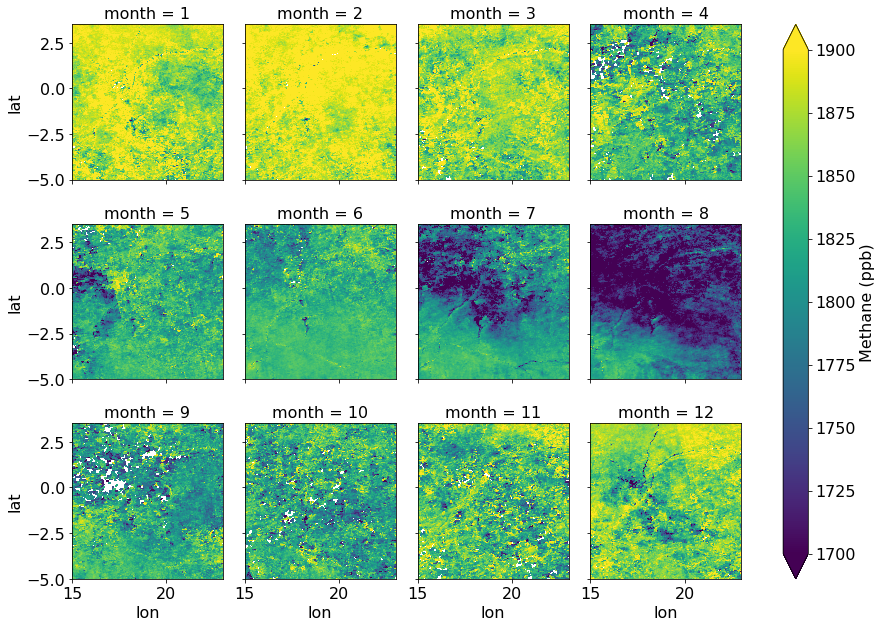

In [98]:
### monthly plots 
### plot also by land type
### isoprene increases with vegetation stress -> more OH/formaldehyde
# plot with month names 
# also plot inter-annual standard deviations
CC_ch4_mean.plot(x='lon',y='lat', col='month', col_wrap = 4, vmin=1700,vmax=1900)
plt.savefig(Images + 'CH4_monthly_ave_CC.png')

## Bateke region comparison

In [69]:
# monthly means
ds = ds_methane_B_final
B_ch4_mean = ds['Methane (ppb)'].groupby('time.month').mean()
#CC_ch4_mean

In [70]:
# grouping by month and year
ds1 = ds_methane_B['Methane (ppb)'].resample(time='1M').mean().to_dataset(name='mean Methane (ppb)')
ds2 = ds_methane_B['Methane (ppb)'].resample(time='1M').std().to_dataset(name = 'RMSE Methane (ppb)')
ds_monthly = xr.merge([ds1,ds2])
ds_monthly

<xarray.Dataset>
Dimensions:             (lat: 423, lon: 275, time: 52)
Coordinates:
  * time                (time) datetime64[ns] 2018-12-31 ... 2023-03-31
  * lon                 (lon) float64 13.72 13.73 13.74 ... 16.17 16.18 16.19
  * lat                 (lat) float64 -4.17 -4.161 -4.152 ... -0.369 -0.36
Data variables:
    mean Methane (ppb)  (time, lat, lon) float64 1.852e+03 1.852e+03 ... nan nan
    RMSE Methane (ppb)  (time, lat, lon) float64 30.51 30.51 30.51 ... nan nan

In [78]:
ch4_monthsB = pd.DataFrame(columns=['Month','All landtypes','All landtypes stdev'])
ch4_monthsB

Empty DataFrame
Columns: [Month, All landtypes, All landtypes stdev]
Index: []

In [79]:
# monthly climatology over the 5 year period 
# add Bateke region average for the savannah pixels, requires a landtype map
# convert this into a pandas dataframe and then plot
ds = B_ch4_mean
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']
ch4_monthsB['Month'] = months
all_vals = []
sav = []
tf = []
ps = []
hws = []

all_vals_stdev = []
sav_stdev  = []
tf_stdev  = []
ps_stdev  = []
hws_stdev  = []

for i in range(len(ds)):
    if i ==0:
        print ('Month','All', 'Savannah', 'Terra Firme', 'Hardwood swamp', 'Palm swamp')
    all_vals.append(np.round(ds[i].mean().values,1))

    
    all_vals_stdev.append(np.round(ds[i].std().values,1))



ch4_monthsB['All landtypes'] = all_vals


ch4_monthsB['All landtypes stdev'] = all_vals_stdev


ch4_monthsB

Month All Savannah Terra Firme Hardwood swamp Palm swamp


Month  All landtypes  All landtypes stdev
0    Jan         1873.0                 22.5
1    Feb         1880.9                 18.4
2    Mar         1868.8                 24.6
3    Apr         1855.1                 29.3
4    May         1786.0                 46.2
5    Jun         1831.7                 13.5
6    Jul         1797.6                 44.0
7    Aug         1764.8                 43.0
8   Sept         1840.1                 29.4
9    Oct         1824.1                 40.3
10   Nov         1851.8                 28.6
11   Dec         1847.7                 48.7

In [80]:
ch4_monthsB = ch4_monthsB.append(ch4_months.loc[0]).reset_index()

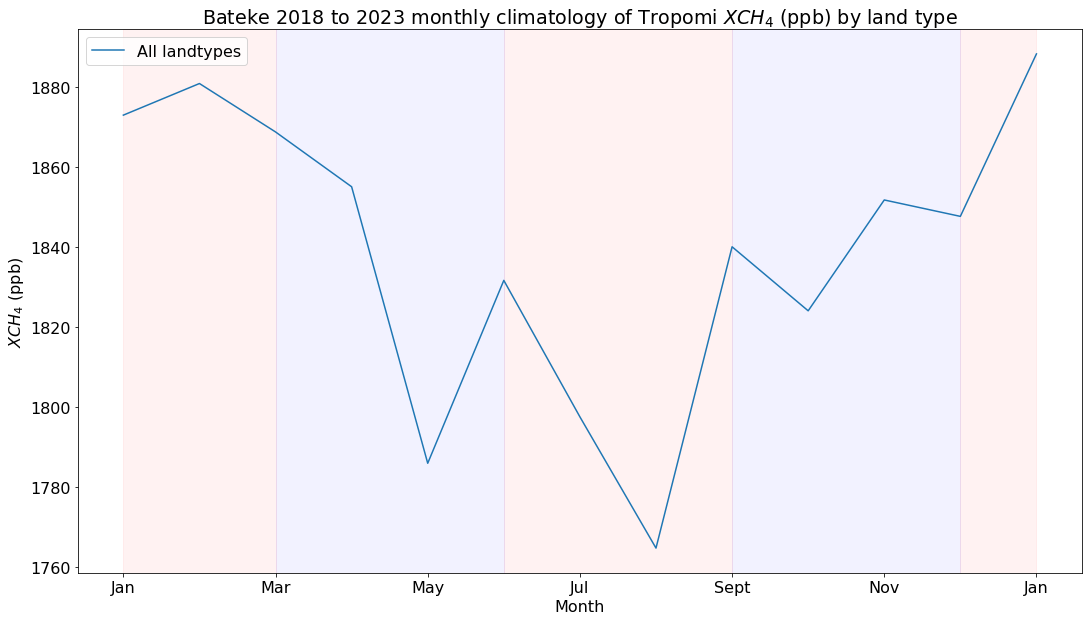

In [81]:
# make this plot better - add standard deviation envelopes
plt.rcParams.update({'font.size':16})
ax = ch4_monthsB.plot('Month',['All landtypes'], figsize=(18,10), \
                     title = 'Bateke 2018 to 2023 monthly climatology of Tropomi $XCH_4$ (ppb) by land type')
ax.set_ylabel("$XCH_4$ (ppb)")
ax.axvspan(0,2, alpha=0.05, color='red')
ax.axvspan(2,5, alpha=0.05, color='blue')
ax.axvspan(5,8, alpha=0.05, color='red')
ax.axvspan(8,11, alpha=0.05, color='blue')
ax.axvspan(11,12, alpha=0.05, color='red')
plt.savefig(Images + 'CH4_monthly_climatology_landtype_Bateke.png')

In [93]:
ch4_months_CC_B = pd.DataFrame(columns=['Month','Cuvette Centrale','Bateke Plateau'])

ch4_months_CC_B['Bateke Plateau'] = ch4_monthsB['All landtypes']
ch4_months_CC_B['Cuvette Centrale'] = ch4_months['All landtypes']
ch4_months_CC_B['Month'] = ch4_monthsB['Month']
ch4_months_CC_B.loc[12,'Cuvette Centrale'] = ch4_months_CC_B.loc[0,'Cuvette Centrale']
ch4_months_CC_B.loc[12,'Bateke Plateau'] = ch4_months_CC_B.loc[0,'Bateke Plateau']
ch4_months_CC_B

Month  Cuvette Centrale  Bateke Plateau
0    Jan            1888.3          1873.0
1    Feb            1901.3          1880.9
2    Mar            1869.5          1868.8
3    Apr            1831.2          1855.1
4    May            1826.9          1786.0
5    Jun            1820.1          1831.7
6    Jul            1743.6          1797.6
7    Aug            1697.5          1764.8
8   Sept            1802.0          1840.1
9    Oct            1819.3          1824.1
10   Nov            1829.3          1851.8
11   Dec            1844.9          1847.7
12   Jan            1888.3          1873.0

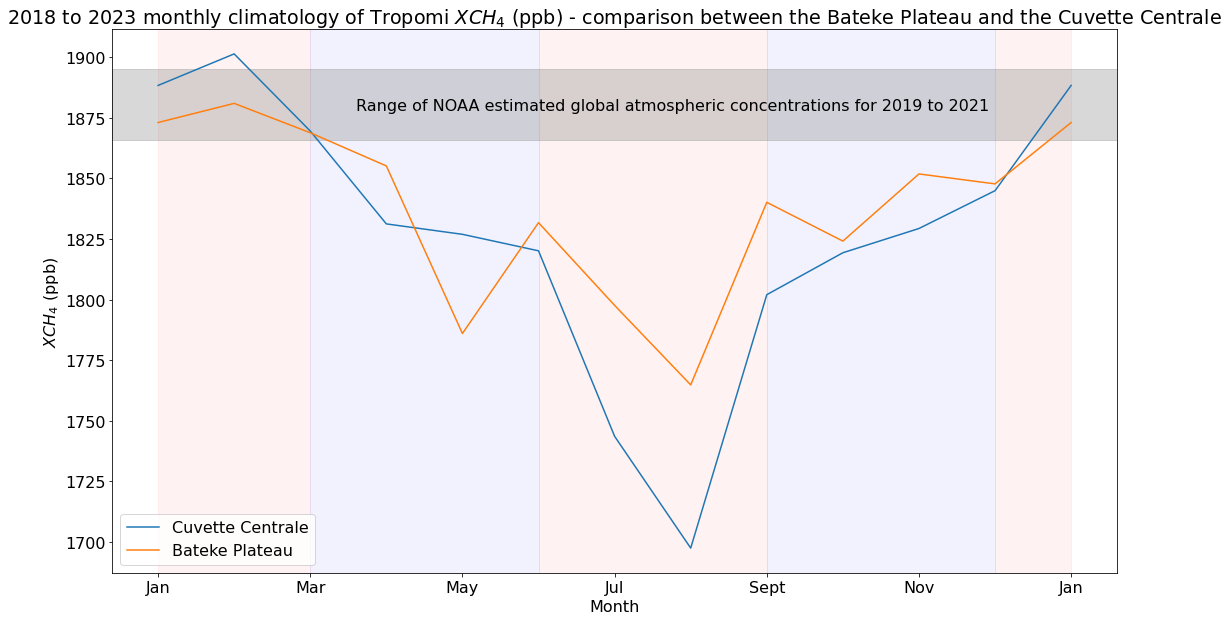

In [95]:
# make this plot better - add standard deviation envelopes
plt.rcParams.update({'font.size':16})

ax = ch4_months_CC_B.plot('Month',['Cuvette Centrale','Bateke Plateau'], figsize=(18,10), \
                     title = '2018 to 2023 monthly climatology of Tropomi $XCH_4$ (ppb) - comparison between the Bateke Plateau and the Cuvette Centrale')
ax.set_ylabel("$XCH_4$ (ppb)")

ax.axvspan(0,2, alpha=0.05, color='red')
ax.axvspan(2,5, alpha=0.05, color='blue')
ax.axvspan(5,8, alpha=0.05, color='red')
ax.axvspan(8,11, alpha=0.05, color='blue')
ax.axvspan(11,12, alpha=0.05, color='red')
ax.axhspan(1866,1895, alpha =0.3, color='grey')
ax.annotate('Range of NOAA estimated global atmospheric concentrations for 2019 to 2021', (2.6,1878))
plt.savefig(Images + 'CH4_monthly_climatology_landtype__CC_B.png', bbox_inches='tight')

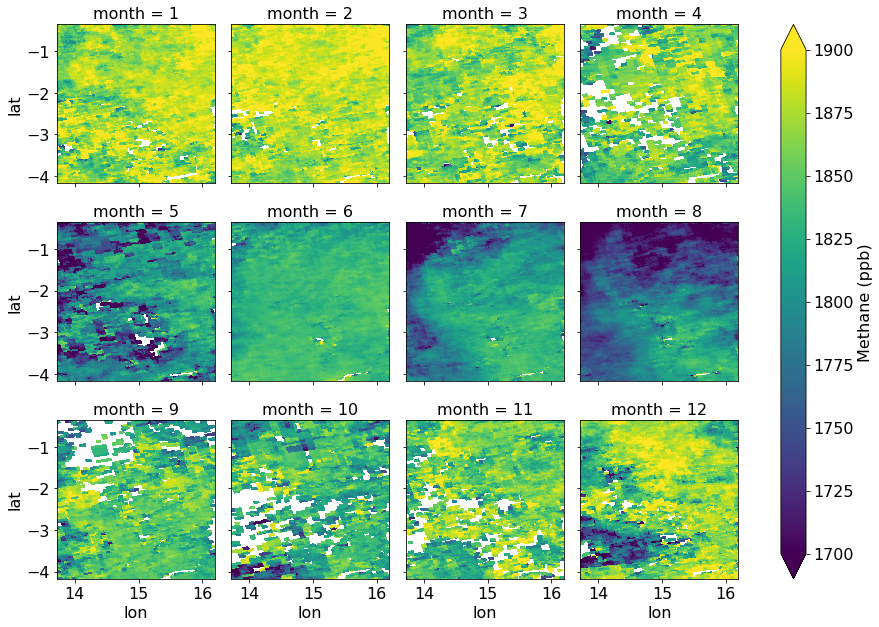

In [97]:
### monthly plots 
### plot also by land type
### isoprene increases with vegetation stress -> more OH/formaldehyde
# plot with month names 
# also plot inter-annual standard deviations
B_ch4_mean.plot(x='lon',y='lat', col='month', col_wrap = 4, vmin=1700,vmax=1900)
plt.savefig(Images + 'CH4_monthly_ave_B.png')

## Water level comparisons
**Quick start option below for opening the interpolated water level data**
- at same resolution/grid as the Tropomi grid

In [47]:
%%time
# takes about 4 mins
# mapping the water level to the same grid as the Tropomi data
# UNCOMMENT THE FOLLOWING LINE TO RE-RUN
#ds = wl_final['water_level'].interp_like(ds_sub['Methane (ppb)'][0])
wl_low_res = ds.to_dataset(name='water level') 
wl_low_res.to_netcdf(DATADIR + 'CH4/wl_low_res3.nc')

CPU times: user 2min 22s, sys: 1min 51s, total: 4min 13s
Wall time: 5min 51s


In [46]:
wl_low_res

<xarray.Dataset>
Dimensions:      (lat: 427, lon: 421, time: 560)
Coordinates:
    band         int64 ...
  * time         (time) datetime64[ns] 2019-03-29 2019-03-30 ... 2020-10-08
  * lat          (lat) float64 -1.083 -1.074 -1.065 -1.056 ... 2.735 2.744 2.753
  * lon          (lon) float64 16.12 16.13 16.14 16.14 ... 19.88 19.89 19.9
Data variables:
    water level  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [100]:
wl_low_res = xr.open_dataset(DATADIR + 'CH4/wl_low_res2.nc')
wl_low_res

<xarray.Dataset>
Dimensions:      (lat: 945, lon: 889, month: 12)
Coordinates:
  * lon          (lon) float64 15.0 15.01 15.02 15.03 ... 22.97 22.98 22.99 23.0
  * lat          (lat) float64 -5.0 -4.991 -4.982 -4.973 ... 3.482 3.491 3.5
  * month        (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water level  (month, lat, lon) float64 ...

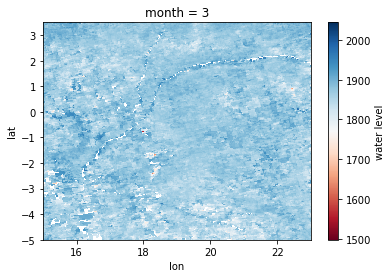

In [44]:
wl_low_res['water level'][2].plot(cmap='RdBu')

In [101]:
%%time
# Combining the water level and methane data into the same dataset
# filtering water level data for the same timesteps as in the ds_methane dataset
# there are not methane entries for all the dates
ds_methane_sub = ds_sub.sel(time=slice('2019-03-29','2020-10-08'))

ds = ds_methane_sub.merge(wl_low_res, compat='override')

#ds_merged = ds.combine_first(ds)

ds_merged = ds.copy()

# filtering for only non-nan pixels in the ALOS images/water level dataset - eventually non-peat forming wetlands could/should be included
ds_merged['Methane (ppb)'] = ds_merged['Methane (ppb)'].where(ds_merged['water level'].notnull())

# filtering the water level for pixels that have methane retrievals, so that the mean values across each time step are representative
ds_merged['water level'] = ds_merged['water level'].where(ds_merged['Methane (ppb)'].notnull())
    
ds_merged




CPU times: user 10.9 s, sys: 45 s, total: 55.9 s
Wall time: 1min 6s


<xarray.Dataset>
Dimensions:        (lat: 945, lon: 889, month: 12, time: 523)
Coordinates:
  * lat            (lat) float64 -5.0 -4.991 -4.982 -4.973 ... 3.482 3.491 3.5
  * lon            (lon) float64 15.0 15.01 15.02 15.03 ... 22.98 22.99 23.0
  * time           (time) datetime64[ns] 2019-03-29 2019-03-30 ... 2020-10-08
    band           int64 1
  * month          (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Methane (ppb)  (time, lat, lon, month) float64 nan nan nan ... nan nan nan
    water level    (month, lat, lon, time) float64 nan nan nan ... nan nan nan

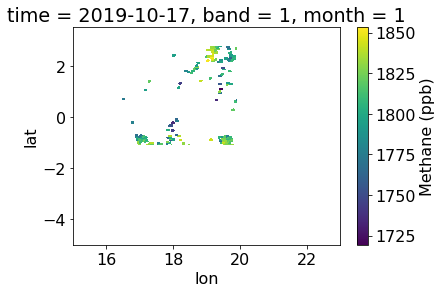

In [108]:
ds_merged['Methane (ppb)'][191][:,:,0].plot()

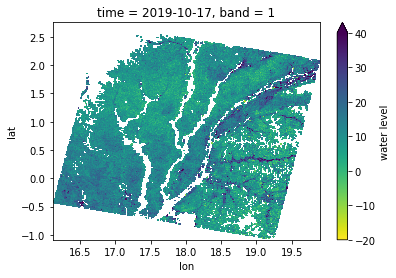

In [159]:
ds['water level'][202].plot(cmap='viridis_r', vmin=-20, vmax=50)

In [109]:
# counting no. of 1km pixels with valid retrievals - this will be used to select/plot images with maximum TROPOMI coverage
indices = []
for i in range(len(ds_merged['Methane (ppb)'])):
    a = ds_merged['Methane (ppb)'][i].count()
    if a > 30000:
        indices.append(i)
        #print(i, a)
        


ValueError: A 3-dimensional array was passed to imshow(), but there is no dimension that could be color.  At least one dimension must be of size 3 (RGB) or 4 (RGBA), and not given as x or y.

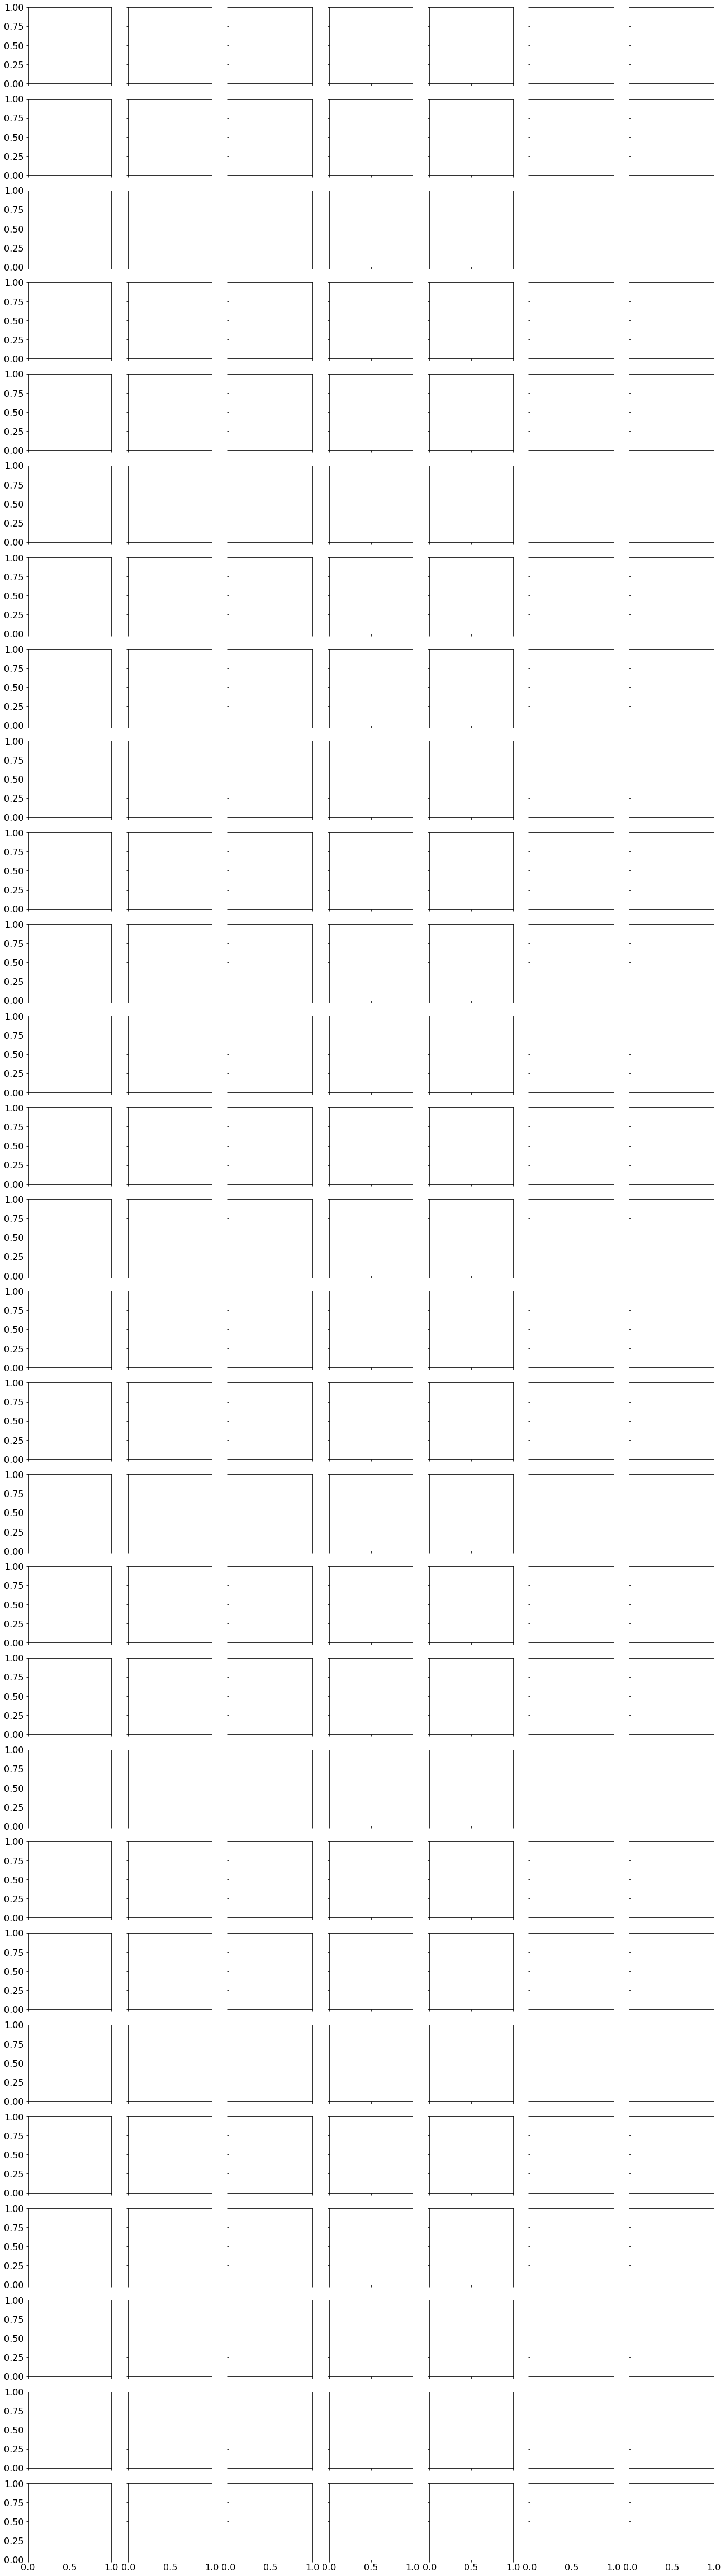

In [110]:
# selecting only the timesteps with e.g., > 30000 pixel count for Methane
da = ds_merged['Methane (ppb)'][indices, :, :]

# plotting in a facetgrid
da.plot.imshow(x='lon', y='lat', col='time', col_wrap=7, robust=True, vmin=1650)

In [ ]:
# selecting only the timesteps with e.g., > 30000 pixel count for Methane
da = ds_merged['water level'][indices, :, :]

# plotting in a facetgrid
da.plot.imshow(x='lon', y='lat', col='time', col_wrap=7, robust=True, cmap='RdBu')

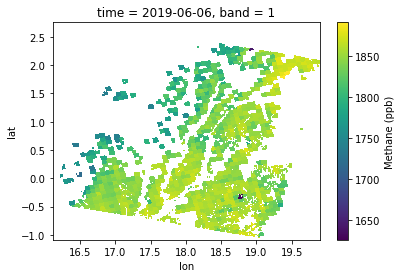

In [186]:
ds_merged['Methane (ppb)'][69].plot()

In [188]:
# average values across whole stack
print (ds_merged['water level'].where(lt_ds.isin([4.0])).mean().values, ds_merged['Methane (ppb)'].where(lt_ds.isin([4.0])).mean().values)

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    band     int64 1
Data variables:
    type     float64 7.367> <bound method Mapping.values of <xarray.Dataset>
Dimensions:  ()
Coordinates:
    band     int64 1
Data variables:
    type     float64 1.833e+03>


<xarray.DataArray 'water level' ()>
array(8.39193343)
Coordinates:
    time     datetime64[ns] 2020-06-12
    band     int64 1


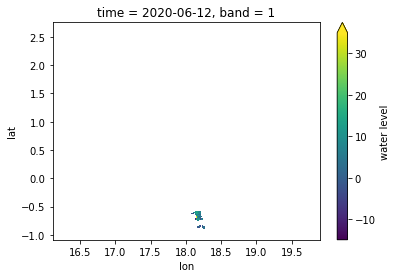

In [189]:
a = 441
ds_merged['water level'][a].plot(cmap='viridis', vmin=-15, vmax=35)
print (ds_merged['water level'][a].mean())
plt.savefig(Images + 'water_level1.png')

<xarray.DataArray 'Methane (ppb)' ()>
array(1709.28923602)
Coordinates:
    time     datetime64[ns] 2020-06-12
    band     int64 1


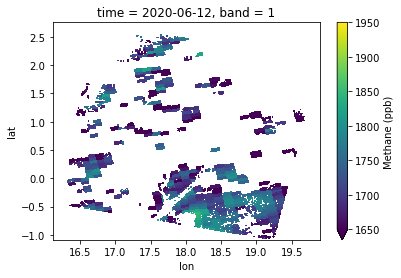

In [161]:

ds_merged['Methane (ppb)'][a].plot(vmin=1650, vmax=1950)
print (ds_merged['Methane (ppb)'][a].mean())
#plt.savefig(Images + 'CH41.png')

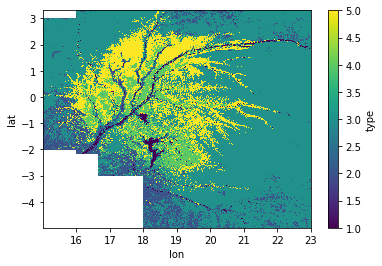

In [116]:
lt_ds['type'].plot()

In [ ]:
ds = ds_merged['Methane (ppb)'].where(lt_trop['type']

In [192]:
# RPRO 
# calculating the mean values along the time dimension and putting them into a dataframe
import pandas as pd
df = pd.DataFrame(columns=['Date','mean WL','mean CH4','mean WL for PS', 'mean CH4 for PS', 'mean WL for HWS', 'mean CH4 for HWS'])
df.Date = ds_merged.time.values

da1 = ds_merged['water level']
da2 = ds_merged['Methane (ppb)']

df['mean WL'] = da1.mean(dim=['lat','lon']).values
df['mean CH4'] = da2.mean(dim=['lat','lon']).values
df['mean WL for PS'] = da1.where(lt_ds['type'].isin([4.0])).mean(dim=['lat','lon']).values
df['mean CH4 for PS'] = da2.where(lt_ds['type'].isin([4.0])).mean(dim=['lat','lon']).values
df['mean WL for HWS'] = da1.where(lt_ds['type'].isin([5.0])).mean(dim=['lat','lon']).values
df['mean CH4 for HWS'] = da2.where(lt_ds['type'].isin([5.0])).mean(dim=['lat','lon']).values
df

Date   mean WL     mean CH4  mean WL for PS  mean CH4 for PS  \
0   2019-03-29 -0.382966  1851.510928        0.377946      1852.430240   
1   2019-03-30  3.992538  1771.497967        4.733884      1777.573086   
2   2019-03-31 -0.623196  1809.545572        1.204341      1821.073698   
3   2019-04-01  3.226001  1839.385948        3.824939      1842.469048   
4   2019-04-02       NaN          NaN             NaN              NaN   
..         ...       ...          ...             ...              ...   
555 2020-10-04  7.914365  1781.340638        9.237954      1784.439115   
556 2020-10-05  7.449049  1695.413146        7.345300      1692.543261   
557 2020-10-06       NaN          NaN             NaN              NaN   
558 2020-10-07       NaN          NaN             NaN              NaN   
559 2020-10-08  6.621825  1807.270296        8.903438      1807.543564   

     mean WL for HWS  mean CH4 for HWS  
0          -0.461562       1851.414078  
1           3.274748       1765.656323  
2          -0.818538       1808.313350  
3           2.882097       1837.615665  
4                NaN               NaN  
..               ...               ...  
555         5.347404       1775.331470  
556         7.675569       1701.679062  
557              NaN               NaN  
558              NaN               NaN  
559         5.043582       1807.081271  

[560 rows x 7 columns]

In [117]:
# OFFL 
# calculating the mean values along the time dimension and putting them into a dataframe
import pandas as pd
df = pd.DataFrame(columns=['Date','mean WL','mean CH4','mean WL - PS', 'mean CH4 - PS', 'mean WL - HWS', 'mean CH4 - HWS'])
df.Date = ds_merged.time.values

da1 = ds_merged['water level']
da2 = ds_merged['Methane (ppb)']

df['mean WL'] = da1.mean(dim=['lat','lon']).values
df['mean CH4'] = da2.mean(dim=['lat','lon']).values
df['mean WL - PS'] = da1.where(lt_ds['type'].isin([4.0])).mean(dim=['lat','lon']).values
df['mean CH4 - PS'] = da2.where(lt_ds['type'].isin([4.0])).mean(dim=['lat','lon']).values
df['mean WL - HWS'] = da1.where(lt_ds['type'].isin([5.0])).mean(dim=['lat','lon']).values
df['mean CH4 - HWS'] = da2.where(lt_ds['type'].isin([5.0])).mean(dim=['lat','lon']).values
df

Date    mean WL     mean CH4  mean WL - PS  mean CH4 - PS  \
0   2019-03-29  -0.560574  1827.332999     -0.006876    1827.249432   
1   2019-03-30   3.155336  1774.562630      3.748399    1775.510039   
2   2019-03-31  -1.032103  1801.500925      0.983895    1798.715077   
3   2019-04-01   4.701764  1837.819649      5.864469    1845.913082   
4   2019-04-02        NaN          NaN           NaN            NaN   
..         ...        ...          ...           ...            ...   
555 2020-10-04   7.964817  1790.393076      9.107455    1790.052556   
556 2020-10-05  13.776083  1713.760376     12.059399    1722.310834   
557 2020-10-06        NaN          NaN           NaN            NaN   
558 2020-10-07        NaN          NaN           NaN            NaN   
559 2020-10-08   6.833562  1813.453797      9.180818    1811.310681   

     mean WL - HWS  mean CH4 - HWS  
0        -0.619766     1827.339590  
1         2.325049     1773.236258  
2        -1.096288     1801.589621  
3         4.395966     1835.691029  
4              NaN             NaN  
..             ...             ...  
555       5.245193     1791.203557  
556      23.503960     1665.307780  
557            NaN             NaN  
558            NaN             NaN  
559       4.997536     1815.130145  

[560 rows x 7 columns]

In [206]:
df = df.dropna()
df

Date    mean WL     mean CH4  mean WL for PS  mean CH4 for PS  \
0   2019-03-29  -0.382966  1851.510928        0.377946      1852.430240   
1   2019-03-30   3.992538  1771.497967        4.733884      1777.573086   
2   2019-03-31  -0.623196  1809.545572        1.204341      1821.073698   
3   2019-04-01   3.226001  1839.385948        3.824939      1842.469048   
6   2019-04-04   7.313246  1729.464552        9.249745      1717.452075   
..         ...        ...          ...             ...              ...   
553 2020-10-02   8.063921  1812.637508        9.059091      1818.941889   
554 2020-10-03  10.236722  1830.058645       13.482674      1835.704506   
555 2020-10-04   7.914365  1781.340638        9.237954      1784.439115   
556 2020-10-05   7.449049  1695.413146        7.345300      1692.543261   
559 2020-10-08   6.621825  1807.270296        8.903438      1807.543564   

     mean WL for HWS  mean CH4 for HWS  
0          -0.461562       1851.414078  
1           3.274748       1765.656323  
2          -0.818538       1808.313350  
3           2.882097       1837.615665  
6           6.070243       1737.175140  
..               ...               ...  
553         6.823190       1804.777501  
554         7.606681       1825.484073  
555         5.347404       1775.331470  
556         7.675569       1701.679062  
559         5.043582       1807.081271  

[319 rows x 7 columns]

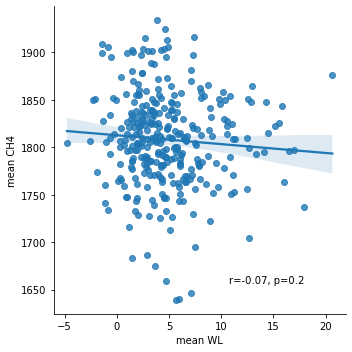

In [213]:

import scipy as sp

g = sns.lmplot(data=df, x='mean WL', y='mean CH4')

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['mean WL'], data['mean CH4'])
    ax = plt.gca()
    ax.text(.6, .1, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

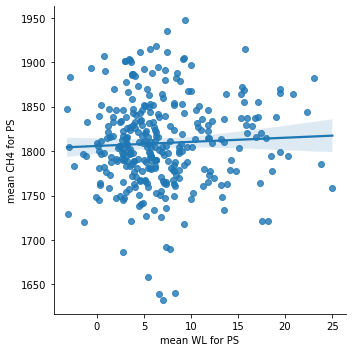

In [195]:
sns.lmplot(data=df, x='mean WL for PS', y='mean CH4 for PS')

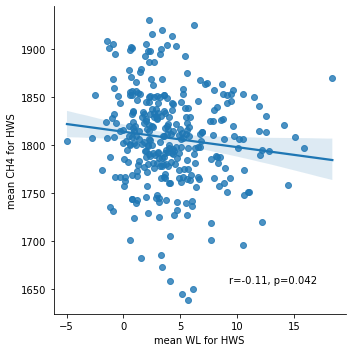

In [212]:
import scipy as sp

g = sns.lmplot(data=df, x='mean WL for HWS', y='mean CH4 for HWS')

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['mean WL for HWS'], data['mean CH4 for HWS'])
    ax = plt.gca()
    ax.text(.6, .1, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

In [120]:
df.mean()

mean WL              4.752620
mean CH4          1806.230798
mean WL - PS         6.920819
mean CH4 - PS     1809.317332
mean WL - HWS        4.132551
mean CH4 - HWS    1805.717173
dtype: float64

<AxesSubplot:xlabel='mean WL - PS', ylabel='mean CH4 - PS'>

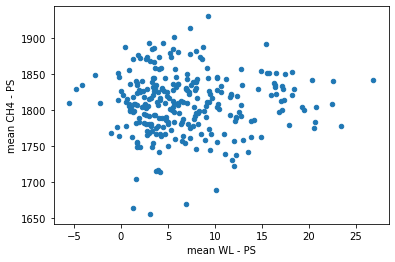

In [118]:
df.plot.scatter('mean WL - PS','mean CH4 - PS')

<AxesSubplot:xlabel='mean WL - HWS', ylabel='mean CH4 - HWS'>

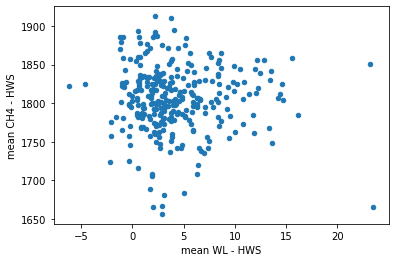

In [119]:
df.plot.scatter('mean WL - HWS','mean CH4 - HWS')

<AxesSubplot:xlabel='mean WL', ylabel='mean CH4'>

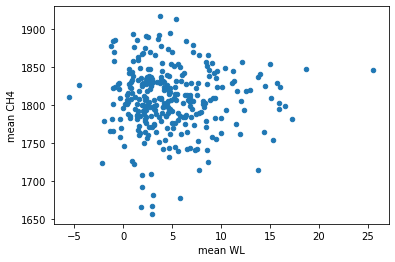

In [105]:
df.plot.scatter('mean WL','mean CH4')

### The following section is just bits and pieces 

In [197]:
index=69
da = wl_low_res['water level'].isel(time=index)
wl_new = da.to_dataset(name = 'water level')
wl_new

<xarray.Dataset>
Dimensions:      (lat: 427, lon: 421)
Coordinates:
    band         int64 ...
    time         datetime64[ns] 2019-06-06
  * lat          (lat) float64 -1.083 -1.074 -1.065 -1.056 ... 2.735 2.744 2.753
  * lon          (lon) float64 16.12 16.13 16.14 16.14 ... 19.88 19.89 19.9
Data variables:
    water level  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

In [ ]:
lt_map_new = lt_map.interp_like(wl_new['water level'][0])
lt_map_new 

In [ ]:
# combining the methane, precision and water level data into the same dataset
# the average pixel landtype is also included

ds_final = xr.merge([wl_new, ds_methane, ds_prec, lt_map_new], join='left')
df = ds_final.to_dataframe().reset_index()
df['type'] = df['type'].astype(int)
df['type'].unique()

In [ ]:
# peatland pixels only
df = df[df['type'].isin([4,5])].reset_index(drop=True)
print (df['type'].unique())

# drop rows without methane data
df = df[df['Methane (ppb)'].notnull()].reset_index(drop=True)

# drop rows without water level data
df = df[df['water level'].notnull()].reset_index(drop=True)

# drop the 'band' column (same for all entries)
df.drop(columns=['band'], axis=1, inplace=True)
df

In [46]:
df[df['type'] == 5].count()

lat              26998
lon              26998
time             26998
band             26998
water level      26998
Methane (ppb)    26998
RMSE (ppb)       26998
type             26998
dtype: int64

In [ ]:
# grouping by lat lon
df1 = df.groupby(['lat','lon','time','type']).mean()
df1 = df1.groupby(level='type').mean().reset_index()

df1['type'].replace({4:'Palm',5:'Hardwood'}, inplace=True)
df1 = df1.rename({'water level':'mean water level (cm)','type':'Swamp type','Methane (ppb)':'methane (ppb)'}, axis=1)
df1['mean water level (cm)'] = np.round(df1['mean water level (cm)'],2)
df1['methane (ppb)'] = np.round(df1['methane (ppb)'],2)
df1['RMSE (ppb)'] = np.round(df1['RMSE (ppb)'],2)
df1

In [ ]:
df.groupby(['type'],level='type').mean()

In [ ]:
df = df.drop(columns=['lat','lon','time','band'], axis=1)

In [ ]:
df['type'] = df['type'].astype('str')

In [ ]:
# add hue = landtype
df.plot.scatter('water level','Methane (ppb)')

1.0


KeyError: '1.0'

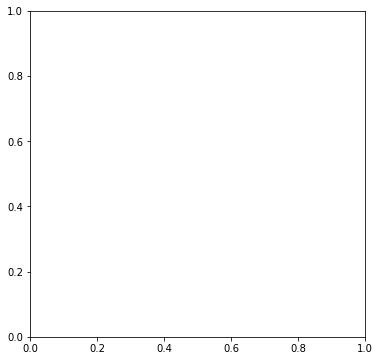

In [67]:
fig, ax = plt.subplots(figsize=(6,6))
grouped = df.groupby('type')
colours = {'4.0': 'blue', '5.0':'orange'}
for key, group in grouped:
    print (key)
    group.plot(ax=ax, kind='scatter', x='water level',y = 'Methane (ppb)', label=key, color = colours[key])

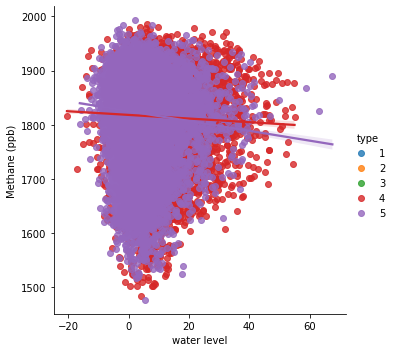

In [72]:
sns.lmplot(data=df, x='water level', y = 'Methane (ppb)', hue='type')

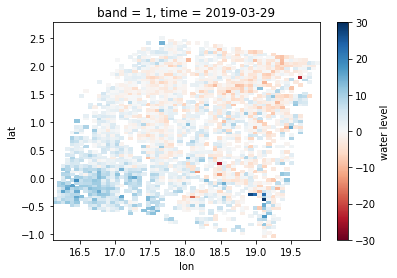

In [22]:
wl_low_res['water level'][0].plot(vmin=-30, vmax=30, cmap='RdBu')

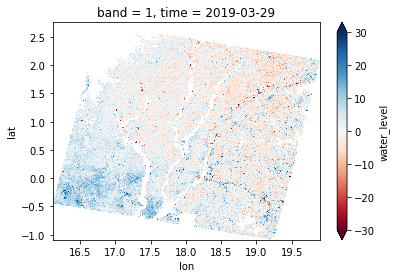

In [67]:
wl_final['water_level'][0][::5,::5].plot(vmin=-30, vmax=30, cmap='RdBu')

In [ ]:
# 

### Mean methane
- add seasonal etc. 

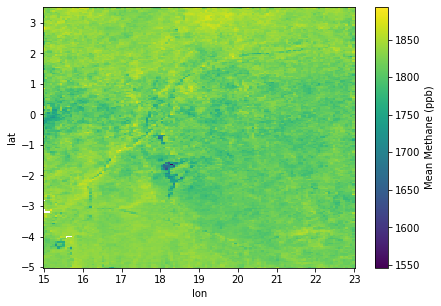

In [4]:
ds_mean = ds_methane['Methane (ppb)'].mean(dim='time')
ds_mean = ds_mean.to_dataset(name='Mean Methane (ppb)')
plt.figure(figsize=[7,4.8])
ds_mean['Mean Methane (ppb)'].plot()
#plt.savefig(Images + 'Tropomi_counts.png', bbox_inches='tight')

<xarray.Dataset>
Dimensions:             ()
Coordinates:
    band                int64 ...
Data variables:
    Mean Methane (ppb)  float64 1.814e+03

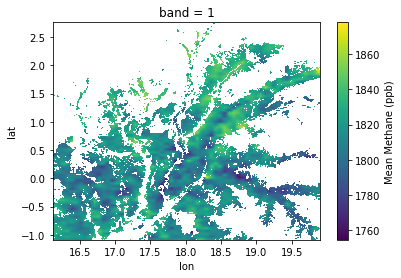

In [52]:
ds = ds_mean.interp_like(lt_map)
ds = ds.where(lt_map['type'].isin([4]))
ds['Mean Methane (ppb)'].plot()
ds.mean()